In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cse551/Youtube_communities.txt
/kaggle/input/cse551/Collin_CYC_Graph.txt
/kaggle/input/cse551/CYC2008_complexes.txt
/kaggle/input/cse551/roadNet_Texas.txt
/kaggle/input/cse551/Undirected_Youtube_network.txt
/kaggle/input/cse551/Email-Enron.txt


In [2]:
!pip install hypernetx matplotlib scikit-learn
!pip install networkx numpy scikit-learn matplotlib
!pip install python-louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.8/583.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 84.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 re

In [19]:
import networkx as nx
import hypernetx as hnx
import matplotlib.pyplot as plt
from collections import defaultdict
import community as community_louvain
from sklearn.metrics import (
    normalized_mutual_info_score,
    adjusted_rand_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    precision_score,
    recall_score,
    f1_score,
)

In [20]:
# Step 1: Load Graph and Hypergraph
def load_collin_cyc_data(filename):
    G = nx.Graph()
    hyperedges = defaultdict(set)

    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith('#'):
                node1, node2 = line.strip().split()
                G.add_edge(node1, node2)
                hyperedges[node1].add(node2)
                hyperedges[node2].add(node1)

    # Convert to hypergraph
    H = hnx.Hypergraph(hyperedges)
    return G, H


In [21]:
# Step 2: Convert Hypergraph to Weighted Graph
def hypergraph_to_weighted_graph(H):
    G_weighted = nx.Graph()
    for edge, nodes in H.incidence_dict.items():
        nodes = list(nodes)
        for i, u in enumerate(nodes):
            for v in nodes[i + 1:]:
                if G_weighted.has_edge(u, v):
                    G_weighted[u][v]['weight'] += 1
                else:
                    G_weighted.add_edge(u, v, weight=1)
    return G_weighted


In [22]:
# Step 3: Graph Community Detection
def graph_community_detection(G):
    return community_louvain.best_partition(G)


# Step 4: Hypergraph Community Detection
def hypergraph_community_detection(H):
    G_weighted = hypergraph_to_weighted_graph(H)
    if G_weighted.number_of_edges() == 0:
        print("No edges in the weighted graph derived from hypergraph. Cannot detect communities.")
        return {}

    partition = community_louvain.best_partition(G_weighted, weight='weight')
    return partition


# Step 5: Extract Communities
def extract_communities(partition):
    communities = defaultdict(set)
    for node, community in partition.items():
        communities[community].add(node)
    return communities

In [23]:
# Step 6: Save Communities to File
def save_communities_to_file(communities, filename):
    with open(filename, 'w') as file:
        for community_id, nodes in communities.items():
            file.write(f"Community {community_id}: {', '.join(nodes)}\n")
    print(f"Communities saved to {filename}")


# Step 7: Print All Communities
def print_all_communities(communities, label="Community"):
    print(f"\n{label} Communities:")
    for community_id, nodes in communities.items():
        print(f"{label} {community_id}: {', '.join(nodes)}")



In [24]:
# Step 8: Visualize Communities
def visualize_communities(G, communities, label="Graph"):
    pos = nx.spring_layout(G, seed=42)
    colors = [f"C{comm_id % 10}" for comm_id in communities.keys()]  
    plt.figure(figsize=(12, 8))

    for comm_id, nodes in communities.items():
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=list(nodes),
            node_color=colors[comm_id % len(colors)],
            label=f"{label} {comm_id}", node_size=50
        )

    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(f"{label} Communities")
    plt.legend()
    plt.show()


In [25]:
# Step 9: Evaluate Clustering Metrics
def evaluate_clustering_metrics(graph_partition, hypergraph_partition):
    common_nodes = set(graph_partition.keys()).intersection(hypergraph_partition.keys())
    if not common_nodes:
        print("No common nodes between graph and hypergraph.")
        return

    true_labels = [graph_partition[node] for node in common_nodes]
    pred_labels = [hypergraph_partition[node] for node in common_nodes]

    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)

    print("\nEvaluation Metrics:")
    print(f"NMI: {nmi:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-measure: {v_measure:.4f}")

In [26]:
# Main Function
def main():
    filename = '/kaggle/input/cse551/Collin_CYC_Graph.txt'

    # Step 1: Load Network Data
    G, H = load_collin_cyc_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    # Step 2: Graph Community Detection
    graph_partition = graph_community_detection(G)
    graph_comm = extract_communities(graph_partition)
    print(f"\nTotal Graph Communities: {len(graph_comm)}")

    # Step 3: Hypergraph Community Detection
    hypergraph_partition = hypergraph_community_detection(H)
    if not hypergraph_partition:
        print("No hypergraph communities detected.")
        return

    hypergraph_comm = extract_communities(hypergraph_partition)
    print(f"\nTotal Hypergraph Communities: {len(hypergraph_comm)}")

    # Step 4: Print Communities
    print_all_communities(graph_comm, "Graph")
    print_all_communities(hypergraph_comm, "Hypergraph")

    # Step 5: Save Communities to File
    save_communities_to_file(graph_comm, "graph_communities.txt")
    save_communities_to_file(hypergraph_comm, "hypergraph_communities.txt")

    # Step 6: Visualize Communities
    #visualize_communities(G, graph_comm, label="Graph")
    #visualize_communities(hypergraph_to_weighted_graph(H), hypergraph_comm, label="Hypergraph")

    # Step 7: Evaluate Clustering Metrics
    evaluate_clustering_metrics(graph_partition, hypergraph_partition)


if __name__ == "__main__":
    main()


Graph loaded with 1097 nodes and 6392 edges.
Hypergraph loaded with 1097 hyperedges.

Total Graph Communities: 153

Total Hypergraph Communities: 80

Graph Communities:
Graph 0: YBR123C, YOR110W, YDR362C, YGR047C, YAL001C, YPL007C
Graph 1: YMR231W, YPL045W, YLR396C, YDR080W, YLR148W, YAL002W, YDL077C
Graph 3: YKL081W, YDR280W, YNL232W, YOL021C, YBR118W, YDL111C, YGL213C, YLR398C, YGR095C, YOL142W, YHR069C, YAL003W, YHR081W, YGR158C, YPR189W, YGR195W, YGR285C, YOR001W, YCR035C, YPL048W, YHR064C, YPR080W
Graph 4: YAR002C-A, YAL007C, YGL200C, YML012W
Graph 5: YBR231C, YJL081C, YNL107W, YDL002C, YDR359C, YBR095C, YMR263W, YPR023C, YDR334W, YPL004C, YLR433C, YPL249C, YKL190W, YDR485C, YDR388W, YGR086C, YDR190C, YCR009C, YMR075W, YNL138W, YNL136W, YFL039C, YGR002C, YGL150C, YNL097C, YEL018W, YJL005W, YML041C, YDR207C, YLR052W, YJR082C, YPL139C, YPL181W, YIL084C, YHR090C, YLR385C, YPL235W, YDL076C, YFL013C, YOR141C, YOR244W, YAL013W, YML057W, YAL011W, YBR109C, YNL059C, YLR085C, YOL004W, YMR19

Graph loaded with 1097 nodes and 6392 edges.
Hypergraph loaded with 1097 hyperedges.

Total Graph Communities: 153


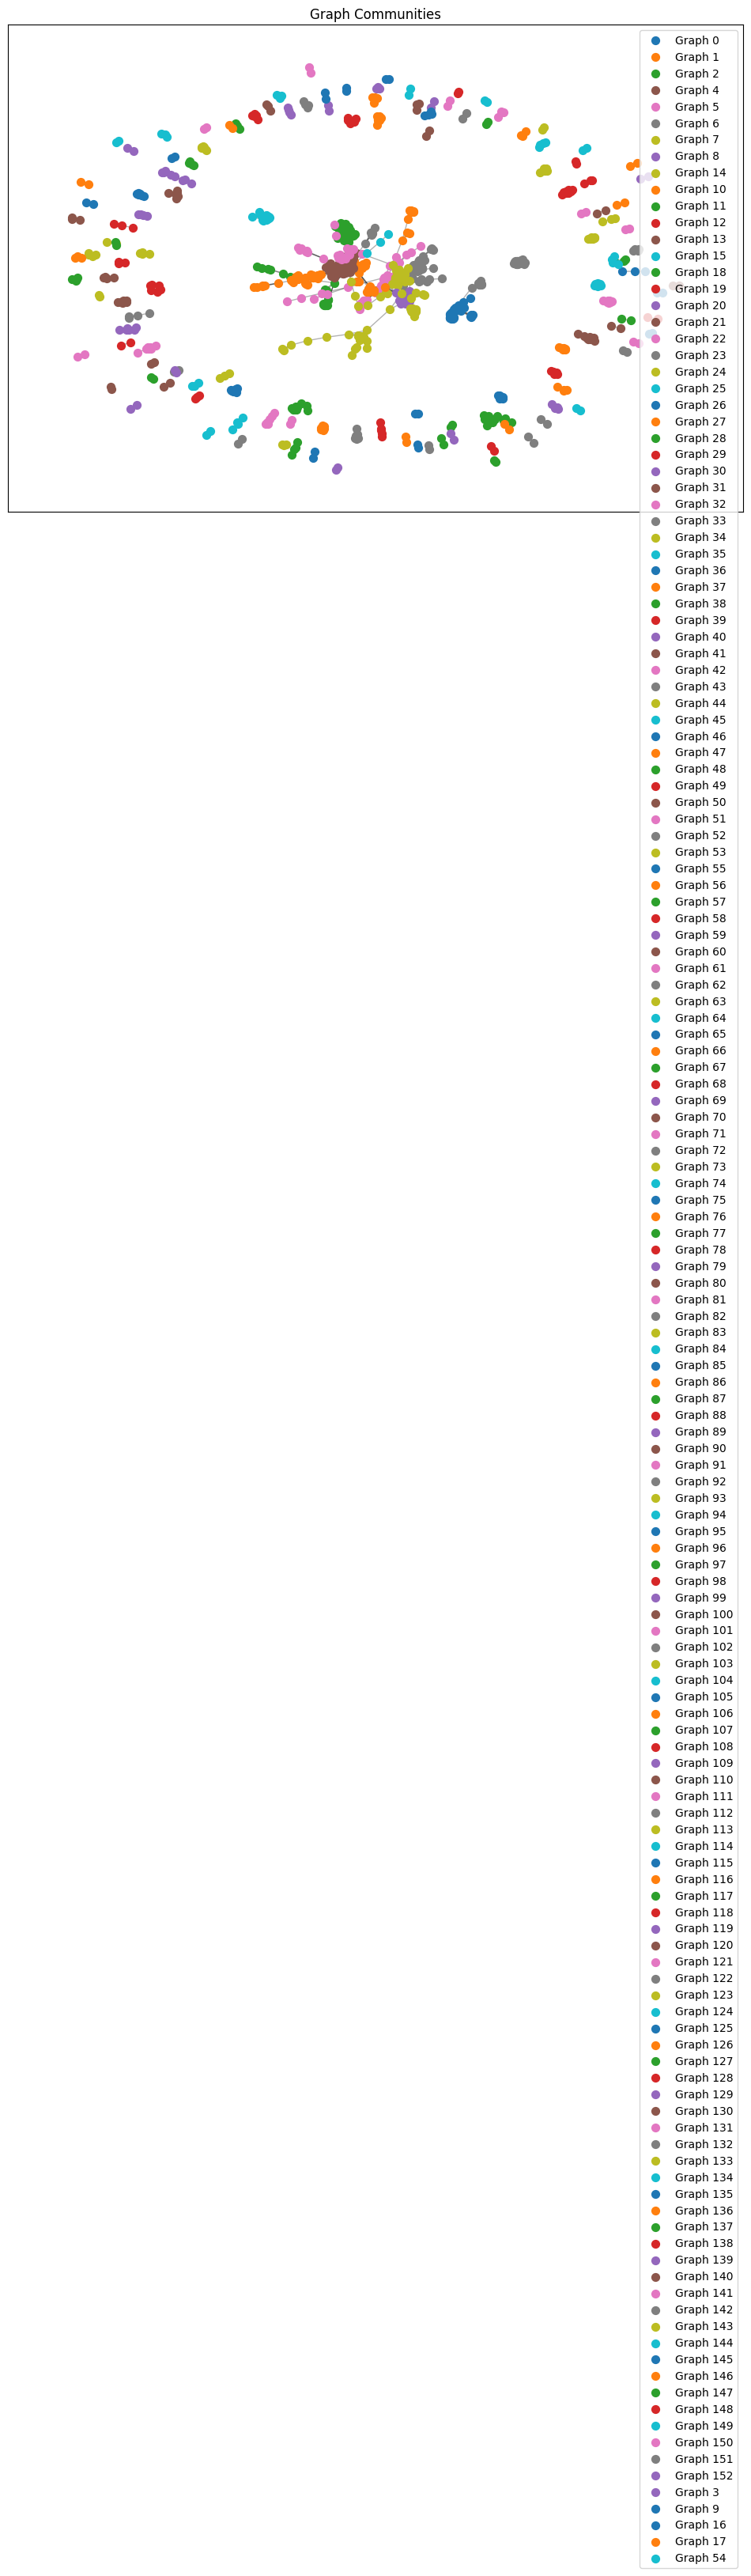

In [27]:
# Main Function
def main():
    filename = '/kaggle/input/cse551/Collin_CYC_Graph.txt'

    # Step 1: Load Network Data
    G, H = load_collin_cyc_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    # Step 2: Graph Community Detection
    graph_partition = graph_community_detection(G)
    graph_comm = extract_communities(graph_partition)
    print(f"\nTotal Graph Communities: {len(graph_comm)}")

    # Step 3: Hypergraph Community Detection
    hypergraph_partition = hypergraph_community_detection(H)
    if not hypergraph_partition:
        print("No hypergraph communities detected.")
        return

    hypergraph_comm = extract_communities(hypergraph_partition)
    #print(f"\nTotal Hypergraph Communities: {len(hypergraph_comm)}")

    # Step 4: Print Communities
    #print_all_communities(graph_comm, "Graph")
    #print_all_communities(hypergraph_comm, "Hypergraph")

    # Step 6: Visualize Communities
    visualize_communities(G, graph_comm, label="Graph")
    #visualize_communities(hypergraph_to_weighted_graph(H), hypergraph_comm, label="Hypergraph")


if __name__ == "__main__":
    main()


Graph loaded with 1097 nodes and 6392 edges.
Hypergraph loaded with 1097 hyperedges.


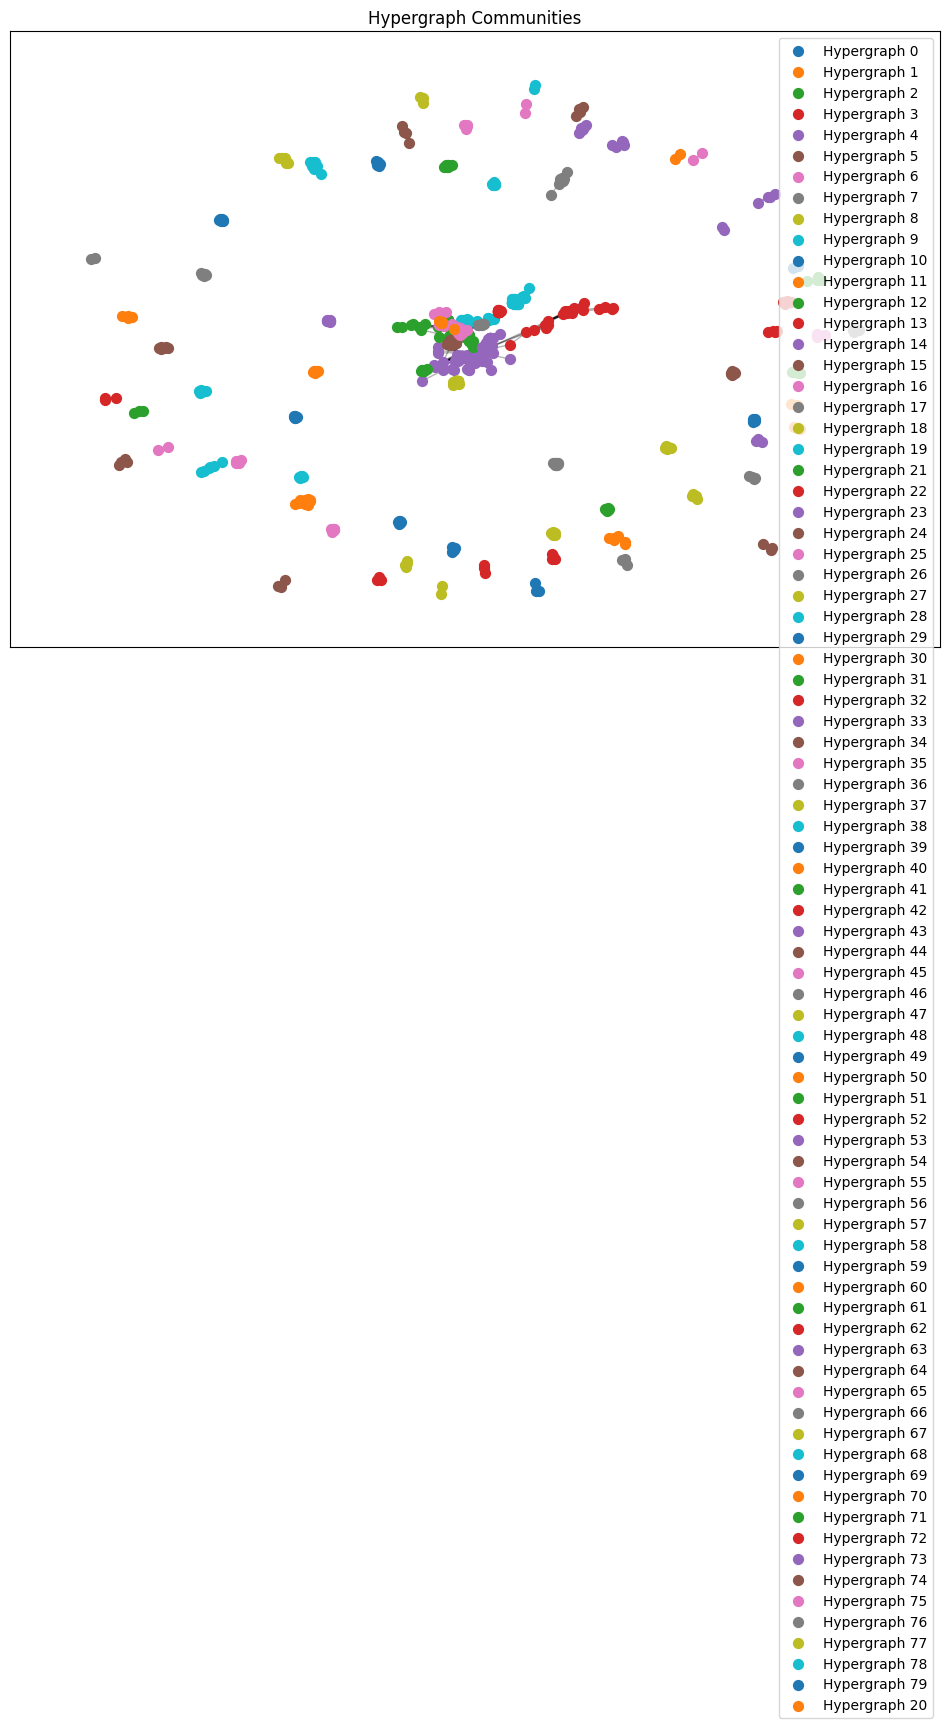

In [28]:
# Main Function
def main():
    filename = '/kaggle/input/cse551/Collin_CYC_Graph.txt'

    # Step 1: Load Network Data
    G, H = load_collin_cyc_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    # Step 2: Graph Community Detection
    graph_partition = graph_community_detection(G)
    graph_comm = extract_communities(graph_partition)
    #print(f"\nTotal Graph Communities: {len(graph_comm)}")

    # Step 3: Hypergraph Community Detection
    hypergraph_partition = hypergraph_community_detection(H)
    if not hypergraph_partition:
        print("No hypergraph communities detected.")
        return

    hypergraph_comm = extract_communities(hypergraph_partition)
    #print(f"\nTotal Hypergraph Communities: {len(hypergraph_comm)}")

    # Step 4: Print Communities
    #print_all_communities(graph_comm, "Graph")
    #print_all_communities(hypergraph_comm, "Hypergraph")

    # Step 6: Visualize Communities
    #visualize_communities(G, graph_comm, label="Graph")
    visualize_communities(hypergraph_to_weighted_graph(H), hypergraph_comm, label="Hypergraph")


if __name__ == "__main__":
    main()


# ------------------------------------------------------------------------------

Graph loaded with 1097 nodes and 6392 edges.
Hypergraph loaded with 1097 hyperedges.


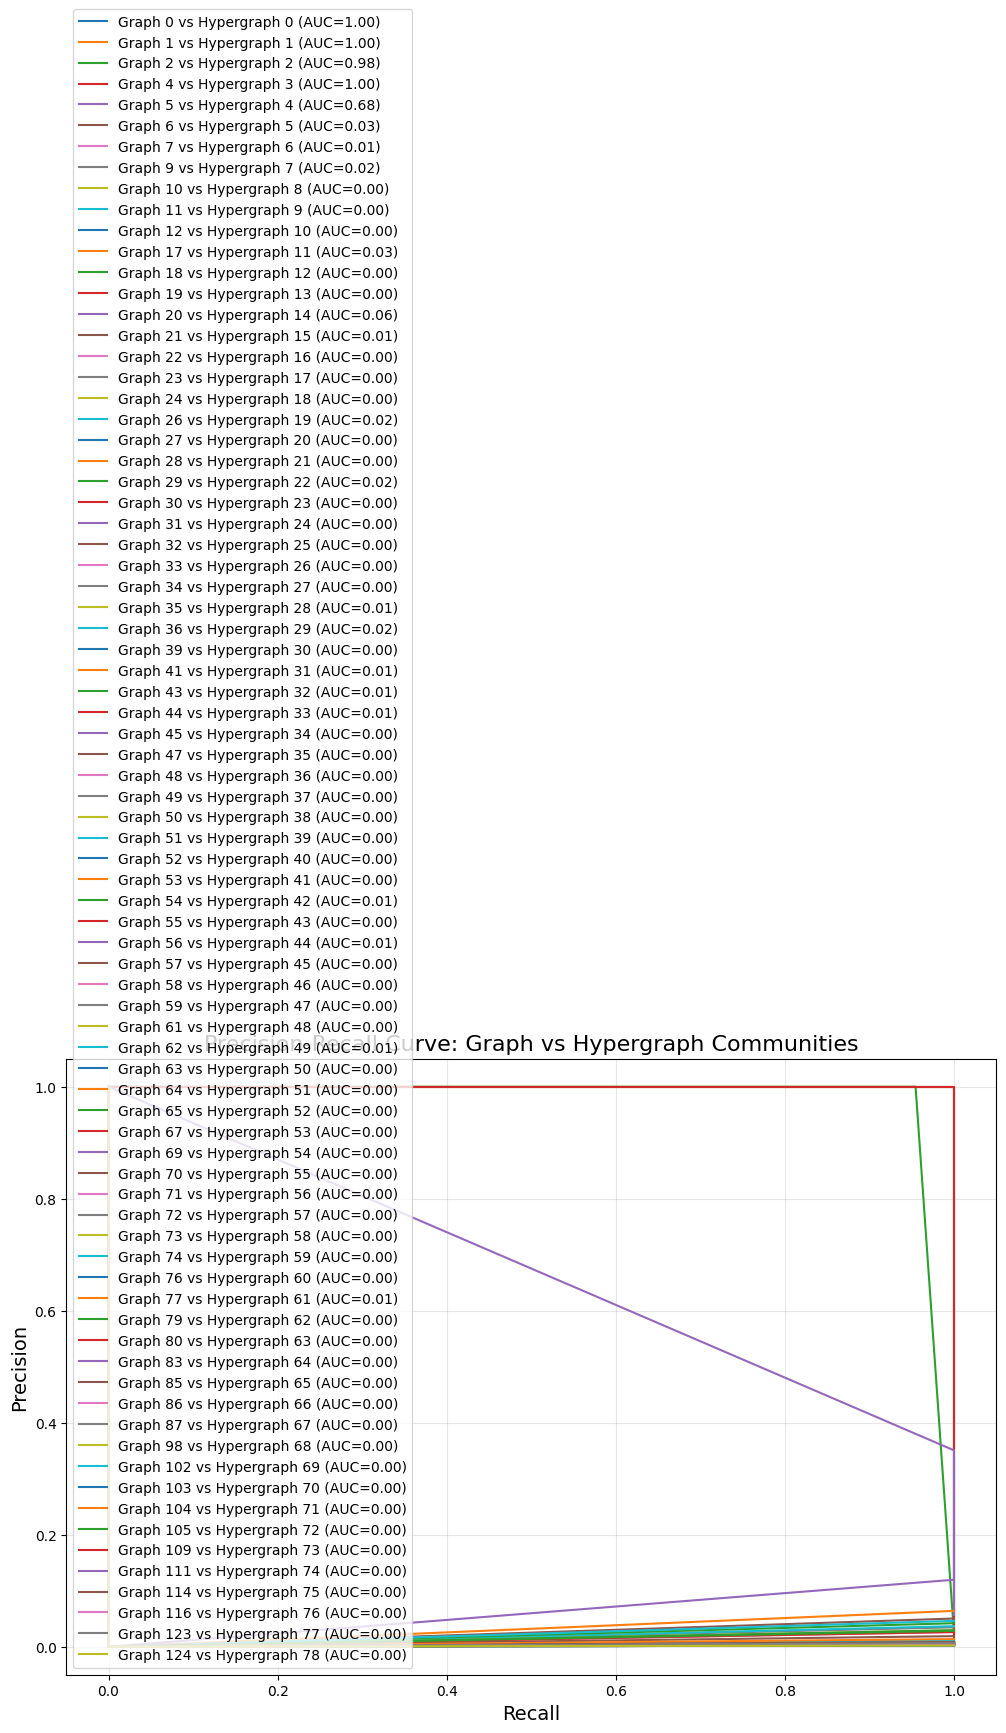

In [8]:
import networkx as nx
import hypernetx as hnx
import matplotlib.pyplot as plt
from collections import defaultdict
import community as community_louvain
from sklearn.metrics import precision_recall_curve, auc
import numpy as np


# Step 1: Load Graph and Hypergraph
def load_collin_cyc_data(filename):
    G = nx.Graph()
    hyperedges = defaultdict(set)

    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith('#'):
                node1, node2 = line.strip().split()
                G.add_edge(node1, node2)
                hyperedges[node1].add(node2)
                hyperedges[node2].add(node1)

    # Convert to hypergraph
    H = hnx.Hypergraph(hyperedges)
    return G, H


# Step 2: Convert Hypergraph to Weighted Graph
def hypergraph_to_weighted_graph(H):
    G_weighted = nx.Graph()
    for edge, nodes in H.incidence_dict.items():
        nodes = list(nodes)
        for i, u in enumerate(nodes):
            for v in nodes[i + 1:]:
                if G_weighted.has_edge(u, v):
                    G_weighted[u][v]['weight'] += 1
                else:
                    G_weighted.add_edge(u, v, weight=1)
    return G_weighted


# Step 3: Graph Community Detection
def graph_community_detection(G):
    return community_louvain.best_partition(G)


# Step 4: Hypergraph Community Detection
def hypergraph_community_detection(H):
    G_weighted = hypergraph_to_weighted_graph(H)
    if G_weighted.number_of_edges() == 0:
        print("No edges in the weighted graph derived from hypergraph. Cannot detect communities.")
        return {}

    partition = community_louvain.best_partition(G_weighted, weight='weight')
    return partition


# Step 5: Plot Precision-Recall Curve
def plot_precision_recall_curve(graph_partition, hypergraph_partition):
    common_nodes = set(graph_partition.keys()).intersection(hypergraph_partition.keys())
    if not common_nodes:
        print("No common nodes between graph and hypergraph.")
        return

    true_labels = [graph_partition[node] for node in common_nodes]
    pred_labels = [hypergraph_partition[node] for node in common_nodes]

    # Map community labels to descriptive names
    graph_communities = sorted(set(true_labels))
    hypergraph_communities = sorted(set(pred_labels))

    # Create binary relevance (one-vs-rest) for multiclass
    plt.figure(figsize=(12, 8))
    for idx, (graph_comm, hyper_comm) in enumerate(zip(graph_communities, hypergraph_communities)):
        y_true = [1 if label == graph_comm else 0 for label in true_labels]
        y_pred = [1 if label == hyper_comm else 0 for label in pred_labels]

        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)

        # Plot the curve
        plt.plot(recall, precision, label=f"Graph {graph_comm} vs Hypergraph {hyper_comm} (AUC={pr_auc:.2f})")

    # Beautify the plot
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title("Precision-Recall Curve: Graph vs Hypergraph Communities", fontsize=16)
    plt.legend(loc="lower left", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()


# Main Function
def main():
    filename = '/kaggle/input/cse551/Collin_CYC_Graph.txt'

    # Step 1: Load Network Data
    G, H = load_collin_cyc_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    # Step 2: Graph Community Detection
    graph_partition = graph_community_detection(G)

    # Step 3: Hypergraph Community Detection
    hypergraph_partition = hypergraph_community_detection(H)
    if not hypergraph_partition:
        print("No hypergraph communities detected.")
        return

    # Step 4: Precision-Recall Curve
    plot_precision_recall_curve(graph_partition, hypergraph_partition)


if __name__ == "__main__":
    main()


Graph loaded with 1097 nodes and 6392 edges.
Hypergraph loaded with 1097 hyperedges.
Communities saved to graph_communities.txt
Communities saved to hypergraph_communities.txt

Graph Communities:
Graph 0: YOR110W, YPL007C, YAL001C, YGR047C, YDR362C, YBR123C
Graph 1: YDL077C, YLR148W, YLR396C, YDR080W, YPL045W, YAL002W, YMR231W
Graph 2: YGR285C, YAL003W, YDL111C, YHR064C, YGL213C, YBR118W, YHR069C, YGR158C, YOL021C, YLR398C, YDR280W, YKL081W, YOL142W, YGR095C, YOR001W, YPR080W, YGR195W, YNL232W, YHR081W, YCR035C, YPL048W, YPR189W
Graph 4: YAR002C-A, YAL007C, YML012W, YGL200C
Graph 5: YKL190W, YPL139C, YBR095C, YPR023C, YLR433C, YLR052W, YJL005W, YAL013W, YFL024C, YDL002C, YPL129W, YMR263W, YDR388W, YOL004W, YFL013C, YLR385C, YMR192W, YCR042C, YDL076C, YMR075W, YDR485C, YBR231C, YJL081C, YNL107W, YDR334W, YOR141C, YCR009C, YML041C, YHR090C, YNL136W, YPL181W, YBR109C, YNL059C, YEL018W, YOR244W, YDR190C, YNL097C, YLR085C, YGL150C, YNL330C, YAL011W, YNL138W, YPL249C, YDR207C, YPL004C, YJR08

/tmp/ipykernel_30/4293084432.py:105: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


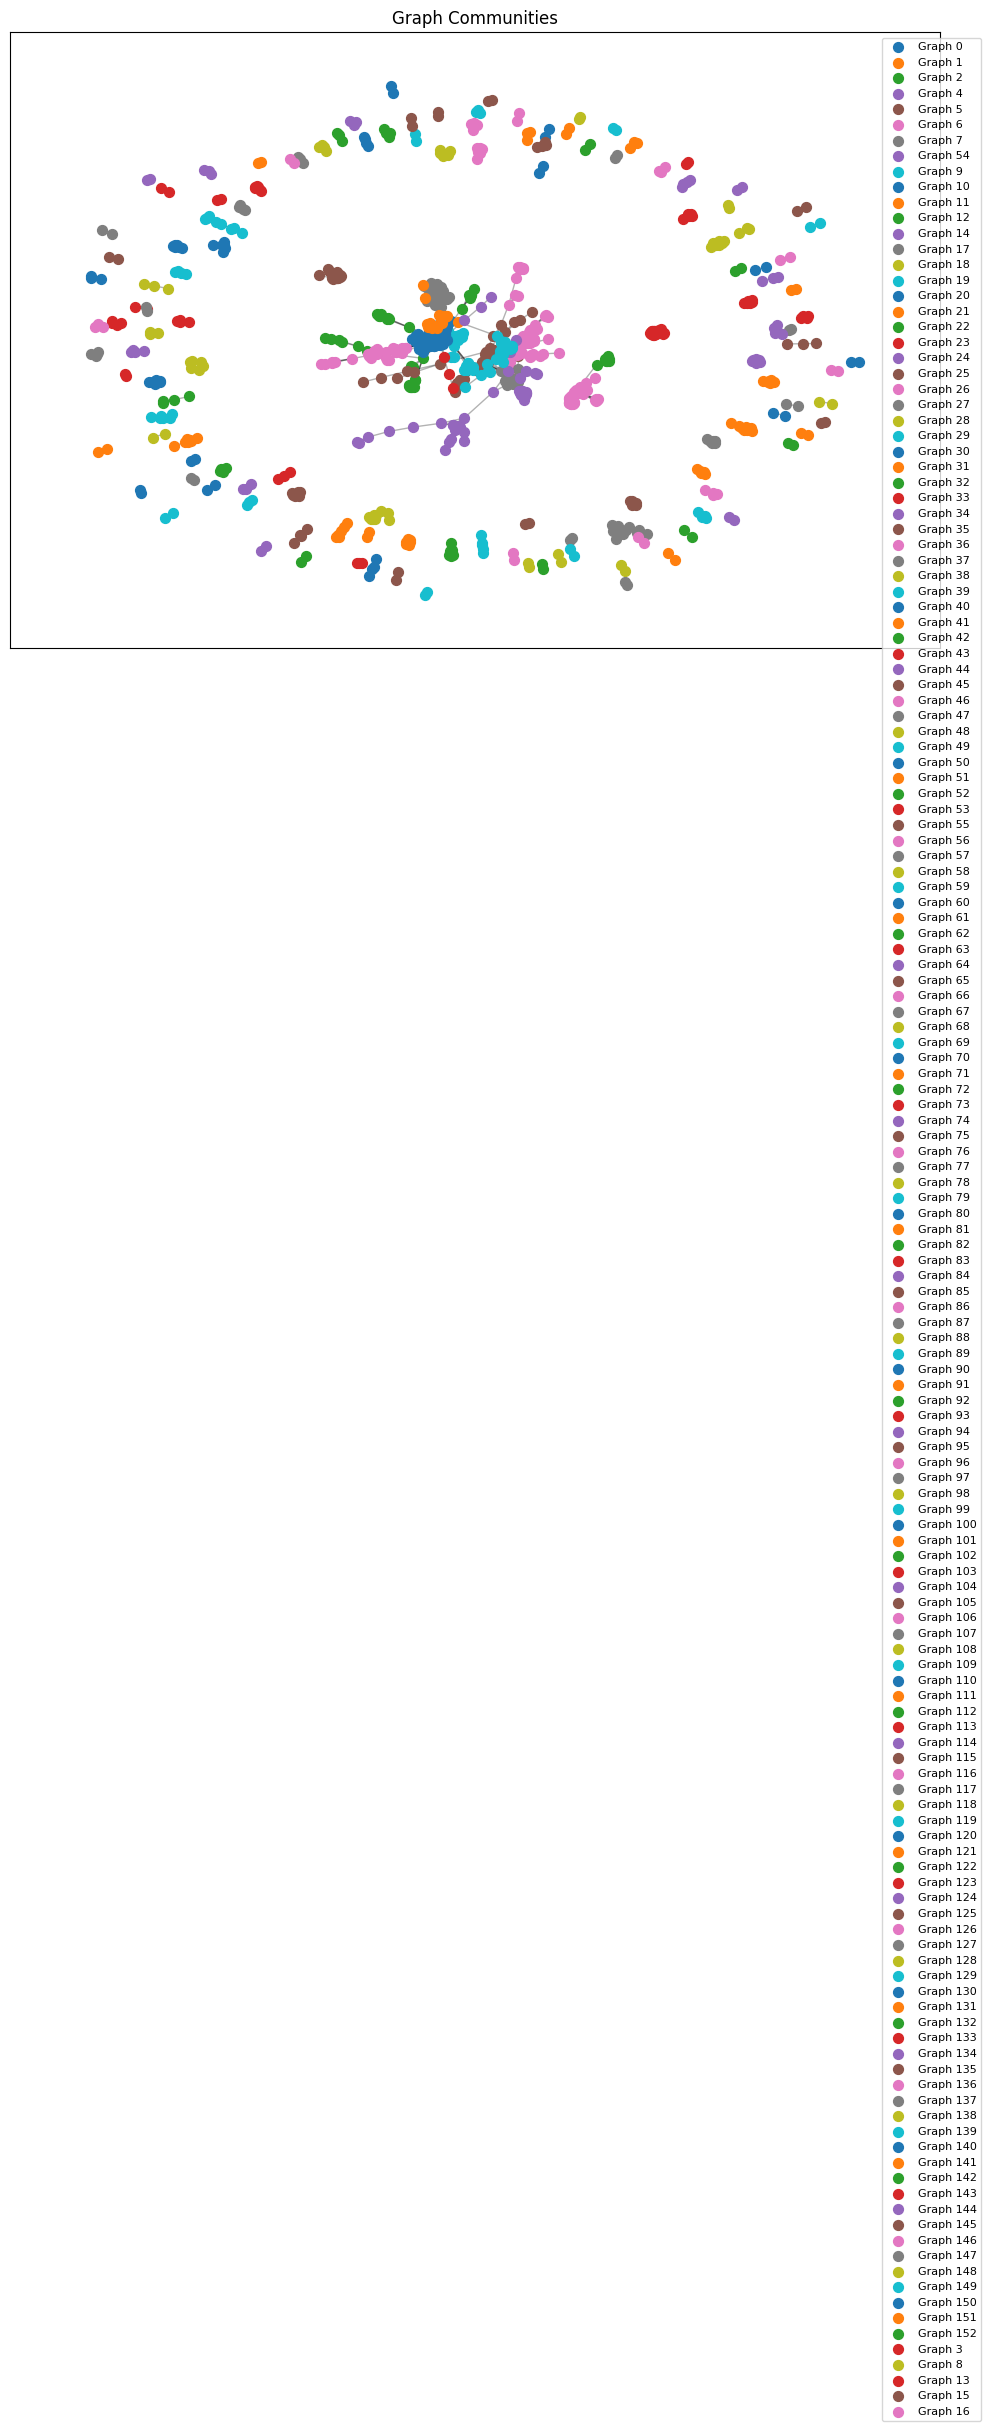

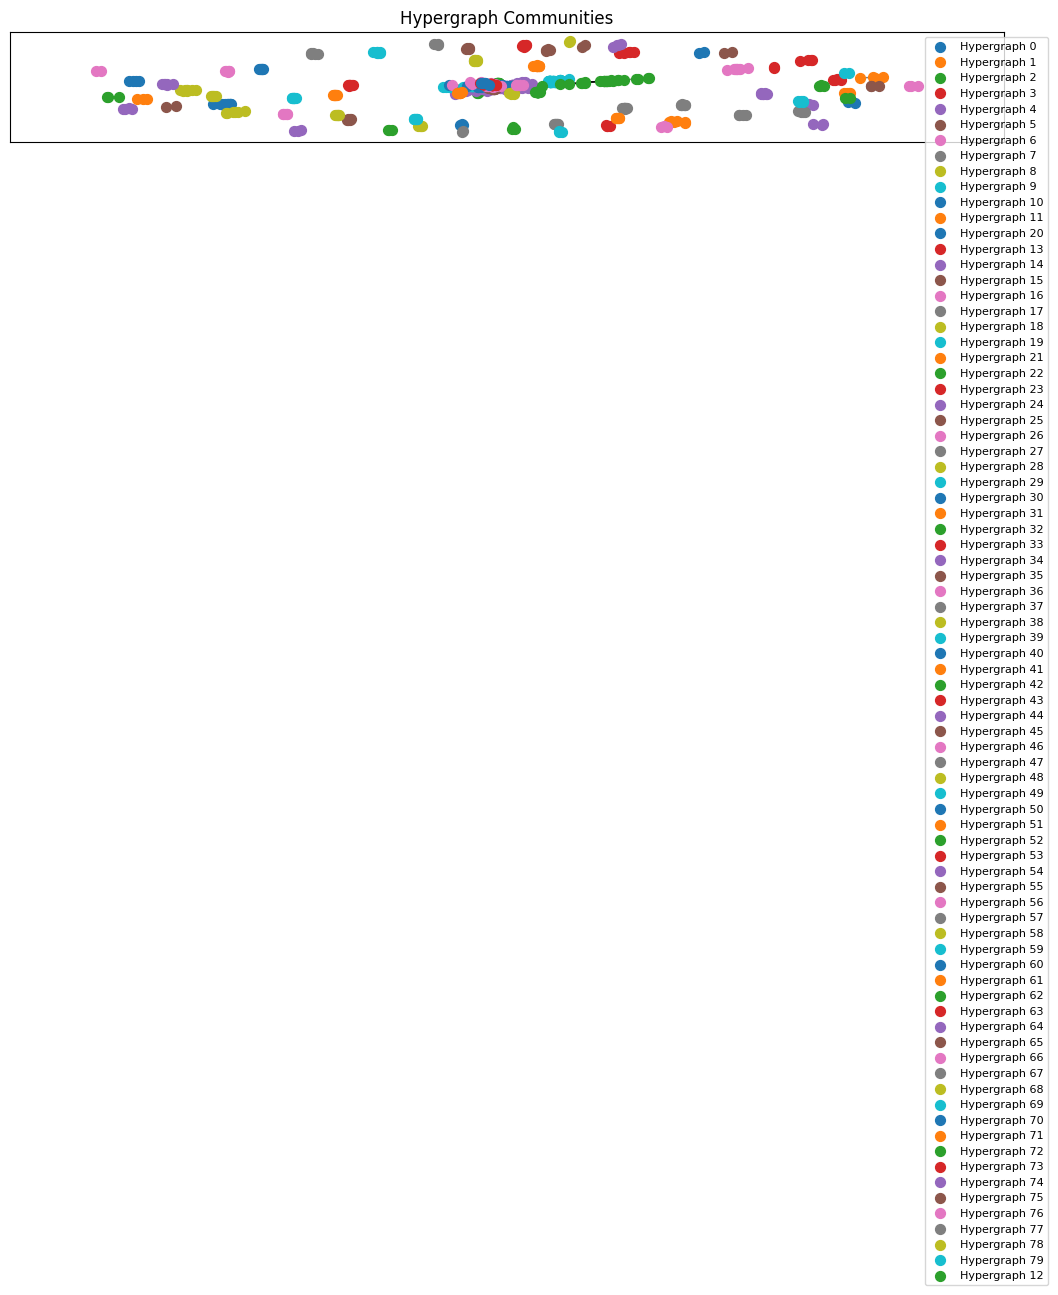

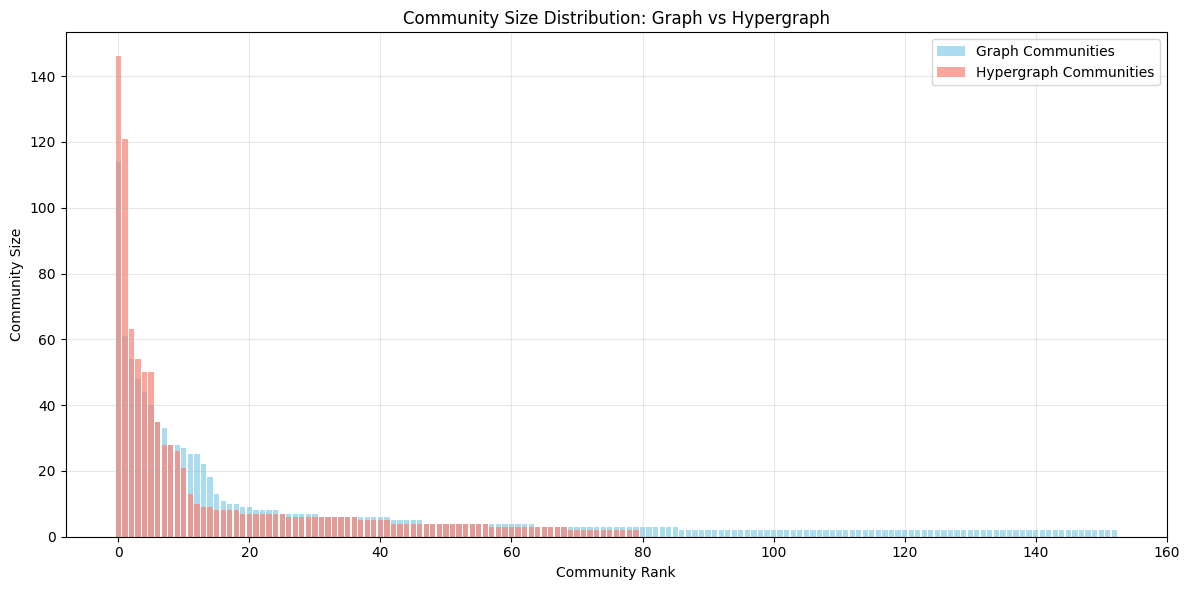

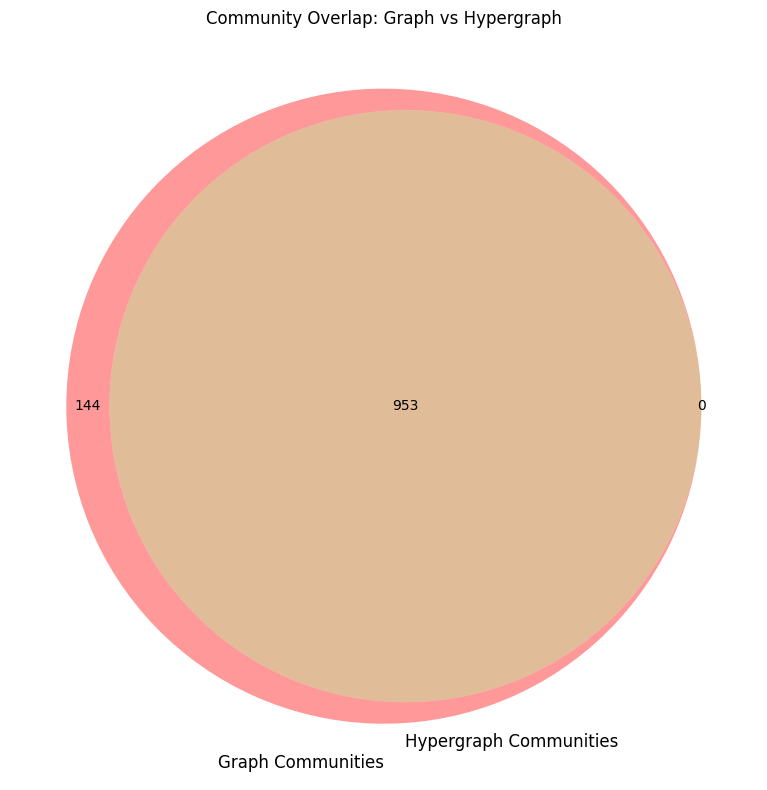

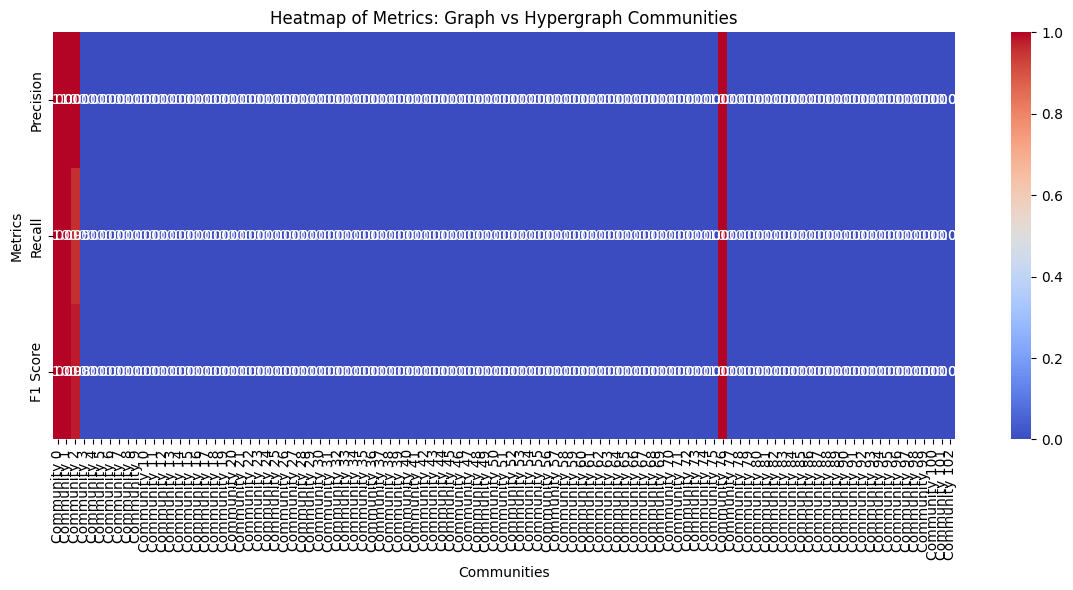

In [11]:
import networkx as nx
import hypernetx as hnx
import matplotlib.pyplot as plt
from collections import defaultdict
import community as community_louvain
from sklearn.metrics import (
    normalized_mutual_info_score,
    adjusted_rand_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    precision_score,
    recall_score,
    f1_score,
)
from matplotlib_venn import venn2
import seaborn as sns
import numpy as np


# Step 1: Load Graph and Hypergraph
def load_collin_cyc_data(filename):
    G = nx.Graph()
    hyperedges = defaultdict(set)

    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith('#'):
                node1, node2 = line.strip().split()
                G.add_edge(node1, node2)
                hyperedges[node1].add(node2)
                hyperedges[node2].add(node1)

    # Convert to hypergraph
    H = hnx.Hypergraph(hyperedges)
    return G, H


# Step 2: Convert Hypergraph to Weighted Graph
def hypergraph_to_weighted_graph(H):
    G_weighted = nx.Graph()
    for edge, nodes in H.incidence_dict.items():
        nodes = list(nodes)
        for i, u in enumerate(nodes):
            for v in nodes[i + 1:]:
                if G_weighted.has_edge(u, v):
                    G_weighted[u][v]['weight'] += 1
                else:
                    G_weighted.add_edge(u, v, weight=1)
    return G_weighted


# Step 3: Community Detection
def graph_community_detection(G):
    return community_louvain.best_partition(G)


def hypergraph_community_detection(H):
    G_weighted = hypergraph_to_weighted_graph(H)
    if G_weighted.number_of_edges() == 0:
        print("No edges in the weighted graph derived from hypergraph. Cannot detect communities.")
        return {}

    partition = community_louvain.best_partition(G_weighted, weight='weight')
    return partition


# Step 4: Extract Communities
def extract_communities(partition):
    communities = defaultdict(set)
    for node, community in partition.items():
        communities[community].add(node)
    return communities


# Step 5: Print All Communities
def print_all_communities(communities, label="Community"):
    print(f"\n{label} Communities:")
    for community_id, nodes in communities.items():
        print(f"{label} {community_id}: {', '.join(nodes)}")


# Step 6: Save Communities to File
def save_communities_to_file(communities, filename):
    with open(filename, 'w') as file:
        for community_id, nodes in communities.items():
            file.write(f"Community {community_id}: {', '.join(nodes)}\n")
    print(f"Communities saved to {filename}")


# Step 7: Visualize Communities
def visualize_communities(G, communities, label="Graph"):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    color_map = sns.color_palette("tab10", len(communities))

    for comm_id, nodes in communities.items():
        nx.draw_networkx_nodes(
            G, pos, nodelist=list(nodes), node_size=50, node_color=[color_map[comm_id % len(color_map)]], label=f"{label} {comm_id}"
        )

    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(f"{label} Communities")
    plt.legend(fontsize=8, loc="best", frameon=True, bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()


# Step 8: Community Size Comparison
def plot_community_sizes(graph_comm, hypergraph_comm):
    plt.figure(figsize=(12, 6))
    graph_sizes = [len(nodes) for nodes in graph_comm.values()]
    hypergraph_sizes = [len(nodes) for nodes in hypergraph_comm.values()]

    plt.bar(range(len(graph_sizes)), sorted(graph_sizes, reverse=True), alpha=0.7, label="Graph Communities", color="skyblue")
    plt.bar(range(len(hypergraph_sizes)), sorted(hypergraph_sizes, reverse=True), alpha=0.7, label="Hypergraph Communities", color="salmon")
    plt.xlabel("Community Rank")
    plt.ylabel("Community Size")
    plt.title("Community Size Distribution: Graph vs Hypergraph")
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Step 9: Community Overlap Venn Diagram
def plot_community_overlap_venn(graph_comm, hypergraph_comm):
    plt.figure(figsize=(8, 8))
    graph_nodes = set.union(*graph_comm.values())
    hypergraph_nodes = set.union(*hypergraph_comm.values())

    venn = venn2([graph_nodes, hypergraph_nodes], ('Graph Communities', 'Hypergraph Communities'))
    plt.title("Community Overlap: Graph vs Hypergraph")
    plt.tight_layout()
    plt.show()


# Step 10: Heatmap of Metrics
def plot_metric_heatmap(graph_partition, hypergraph_partition):
    plt.figure(figsize=(12, 6))
    common_nodes = set(graph_partition.keys()).intersection(hypergraph_partition.keys())
    if not common_nodes:
        print("No common nodes between graph and hypergraph.")
        return

    true_labels = [graph_partition[node] for node in common_nodes]
    pred_labels = [hypergraph_partition[node] for node in common_nodes]

    metrics = {
        "Precision": precision_score(true_labels, pred_labels, average=None, zero_division=0),
        "Recall": recall_score(true_labels, pred_labels, average=None, zero_division=0),
        "F1 Score": f1_score(true_labels, pred_labels, average=None, zero_division=0),
    }

    metric_matrix = np.array(list(metrics.values()))
    metric_labels = list(metrics.keys())

    sns.heatmap(metric_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=[f"Community {i}" for i in range(metric_matrix.shape[1])], yticklabels=metric_labels)
    plt.title("Heatmap of Metrics: Graph vs Hypergraph Communities")
    plt.xlabel("Communities")
    plt.ylabel("Metrics")
    plt.tight_layout()
    plt.show()


# Main Function
def main():
    filename = '/kaggle/input/cse551/Collin_CYC_Graph.txt'

    # Load Network Data
    G, H = load_collin_cyc_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    # Graph Community Detection
    graph_partition = graph_community_detection(G)
    graph_comm = extract_communities(graph_partition)

    # Hypergraph Community Detection
    hypergraph_partition = hypergraph_community_detection(H)
    hypergraph_comm = extract_communities(hypergraph_partition)

    # Save and Print Communities
    save_communities_to_file(graph_comm, "graph_communities.txt")
    save_communities_to_file(hypergraph_comm, "hypergraph_communities.txt")
    print_all_communities(graph_comm, "Graph")
    print_all_communities(hypergraph_comm, "Hypergraph")

    # Visualizations
    visualize_communities(G, graph_comm, label="Graph")
    visualize_communities(hypergraph_to_weighted_graph(H), hypergraph_comm, label="Hypergraph")
    plot_community_sizes(graph_comm, hypergraph_comm)
    plot_community_overlap_venn(graph_comm, hypergraph_comm)
    plot_metric_heatmap(graph_partition, hypergraph_partition)


if __name__ == "__main__":
    main()
